# Contrastive Learning
In questo file troviamo un modello di rete neurale per la classificazione del dataset COVID-CXR4.\
IL dataset è stato scaricato da [Kaggle](https://www.kaggle.com/datasets/andyczhao/covidx-cxr2) e messo dentro la cartella datasets \(questa cartella è ignorata da git perchè il dataset è grosso)\
I modelli salvati si possono trovare sotto la cartella [models](models) in modo da poterli usare senza rifare l'addestramento.

Questo *interactive pyhon notebook* è stato diviso in 3 parti principali:
- **Autoencoder**: in cui viene creato l'autoencoder.
- **Classifier**: in cui viene creato il classificatore.
- **Contrastive Learning**: in cui viene applicata la tecnica di contrastive learning per migliorare gli embedding da passare al classificatore.

Ogni parte del notebook contiene anche dei grafici e immagini per mostrare come i vari modelli si comportano.\
In questa prima parte vengono importati le varie librerie usate e vengono create le variabili globali.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, models, callbacks, ops, backend
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
temperature = 1
use_rand_each_epoch = False
balance_classes = False
epochs = 20
batch = 1024

root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
predictions_path = f"{root}/datasets/{dataset_name}_predictions.npz"
model_save_path = f"{root}/models/{dataset_name}_siamese.keras"
classifier_path = f"{root}/models/{dataset_name}_classifier.keras"

Qui prendiamo tutti i dati necessari per la creazione del dataset

In [2]:
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

predictions = np.load(predictions_path, allow_pickle=True)
y_train_pred = predictions['y_train_pred']
y_val_pred = predictions['y_val_pred']
y_test_pred = predictions['y_test_pred']

latent_space = x_train.shape[1]

Siccome gli esempi sbagliati sono sicuramente non bilanciati, que vediamo di quanto

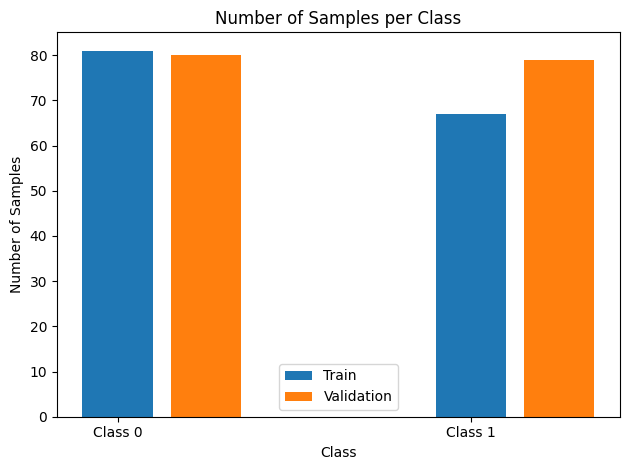

In [3]:
classes = len(np.unique(y_train))

incorrect_pred_i = np.where(y_train != y_train_pred)[0]
y_true = y_train[incorrect_pred_i]
train_counts = np.bincount(y_true)
assert train_counts.shape != (0,), "No training errors found, cannot use contrastive learning."

incorrect_pred_i = np.where(y_val != y_val_pred)[0]
y_true = y_val[incorrect_pred_i]
val_counts = np.bincount(y_true)

plt.figure()
x_labels = range(classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.legend()
plt.tight_layout()
plt.show()


Di seguito creiamo le coppie di dati in modo che prendano le rappresentazioni etichettate in modo errato e quelle etichettate correttamente:
- coppie positive se la classe originaria è uguale --> distanza 0
- coppie negative se la classe originaria è diversa --> distanza 1

In [4]:
class ContrastivePairs():
    x: list[np.ndarray]
    examples: list[np.ndarray]
    labels: list[int]

    def __init__(self, index: int, x: np.ndarray, positive_examples: list[int], negative_examples: list[int]):
        assert len(positive_examples) == len(negative_examples), "Positive and negative examples must have the same length."
        positive_examples = [x[pos] for pos in positive_examples]
        negative_examples = [x[neg] for neg in negative_examples]

        self.examples = positive_examples + negative_examples
        self.labels = [0] * len(positive_examples) + [1] * len(negative_examples)
        self.x = [x[index]] * len(self.examples)

    def build(self):
        i = np.arange(len(self.labels))
        np.random.shuffle(i)
        return (np.array(self.x), np.array(self.examples)[i]), np.array(self.labels)[i]

class ClassesPredictions():
    x: np.ndarray
    y_true: np.ndarray
    y_pred: np.ndarray
    classes: int
    correct_i: list[np.ndarray]
    incorrect_i: list[np.ndarray]

    def __init__(self, x: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray, balance_classes: bool = False):
        self.x = x
        self.y_true = y_true
        self.y_pred = y_pred

        self.classes = len(np.unique(y_true))
        correct_indices = np.where(y_true == y_pred)[0]
        incorrect_indices = np.where(y_true != y_pred)[0]

        self.correct_i = [correct_indices[y_true[correct_indices] == i] for i in range(self.classes)]
        self.incorrect_i = [incorrect_indices[y_true[incorrect_indices] == i] for i in range(self.classes)]

        if balance_classes:
            minimum_class_size = min([len(i) for i in self.incorrect_i])
            self.incorrect_i = [np.random.choice(i, minimum_class_size, replace=False) for i in self.incorrect_i]

    def get_list_pairs(self, batch: int) -> list[ContrastivePairs]:
        assert batch // 2 > 0, "Batch size must be at least 2."
        assert batch % 2 == 0, "Batch size must be even."

        pairs_per_class = batch // 2
        replace = min([len(i) for i in self.correct_i]) < pairs_per_class

        pairs = []
        for incorrect_list in self.incorrect_i:
            for idx in incorrect_list:
                class_ok = self.y_true[idx]
                class_no = self.y_pred[idx]

                pos_examples = np.random.choice(self.correct_i[class_ok], pairs_per_class, replace=replace)
                neg_examples = np.random.choice(self.correct_i[class_no], pairs_per_class, replace=replace)

                pairs.append(ContrastivePairs(idx, self.x, pos_examples, neg_examples))
        return pairs

def pairs_generator(x, y_true, y_pred, batch, use_rand_each_epoch=False, balance_classes=False):
    pred = ClassesPredictions(x, y_true, y_pred, balance_classes=balance_classes)
    pairs_list = pred.get_list_pairs(batch)
    yield len(pairs_list)

    while True:
        np.random.shuffle(pairs_list)
        for pair in pairs_list:
            yield pair.build()
        if use_rand_each_epoch:
            pairs_list = pred.get_list_pairs(batch)

gen_train_pair = pairs_generator(x_train, y_train, y_train_pred, batch, use_rand_each_epoch=use_rand_each_epoch, balance_classes=balance_classes)
gen_val_pair = pairs_generator(x_val, y_val, y_val_pred, batch, use_rand_each_epoch=use_rand_each_epoch, balance_classes=balance_classes)
batch_train_pairs_steps = next(gen_train_pair)
batch_val_pairs_steps = next(gen_val_pair)

print(f"Train pairs: {batch} * {batch_train_pairs_steps}")
print(f"Validation pairs: {batch} * {batch_val_pairs_steps}")

Train pairs: 1024 * 148
Validation pairs: 1024 * 159


Questo codice implementa due loss functions.\
In particolare per problemi di apprendimento contrastivo, come il confronto tra coppie di campioni vengono usate le seguenti loss:

1. contrastive_loss: calcola la perdita contrastiva standard.\
   Penalizza le coppie di campioni in base alla loro distanza predetta (y_pred) e alla loro etichetta reale (y_true).\
   Se i campioni sono simili (y_true=0), penalizza le distanze grandi.\
   Se i campioni sono diversi (y_true=1), penalizza le distanze piccole.
2. contrastive_SNN_loss: calcola una variante della perdita contrastiva basata su una funzione softmax normalizzata.\
   Utilizza una temperatura (temperature) per controllare la "morbidezza" della penalizzazione.\
   Penalizza le coppie in base alla probabilità relativa di similarità, calcolata come rapporto tra le distanze esponenziali normalizzate.\
   La loss usata è la [Soft Nearest Neighbors Loss](https://lilianweng.github.io/posts/2021-05-31-contrastive/#soft-nearest-neighbors-loss)
3. contrastive_Sig_loss: calcola una variante della perdita contrastiva basata sulla funzione sigmoide.
   La loss usata è la [Sigmoid Contrastive Loss](https://openreview.net/pdf?id=8QCupLGDT9)

In [5]:
def distance(vects):
    """
    Computes the cosine distance between pairs of vectors.
    """
    x, y = vects[:,0], vects[:,1]
    x = ops.normalize(x, axis=1)
    y = ops.normalize(y, axis=1)

    x = ops.nan_to_num(x)
    y = ops.nan_to_num(y)

    similarity = ops.sum(x * y, axis=1)
    return (1 - similarity) / 2

def loss(margin=1.0, temperature=1.0, bias=0.0):
    """
    Contrastive loss function for Siamese networks.
    Args:
        margin (float): Margin for the contrastive loss.
        temperature (float): Temperature parameter for the loss.
        bias (float): Bias term for the loss.
    Returns:
        A loss function that can be used in model compilation.
    """
    temperature_SL = ops.exp(temperature)

    @keras.saving.register_keras_serializable()
    def contrastive_loss(y_true, y_pred):
        dist = distance(y_pred)
        square_pred = ops.square(dist)
        margin_square = ops.square(ops.maximum(margin - (dist), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    @keras.saving.register_keras_serializable()
    def contrastive_SNN_loss(y_true, y_pred):
        dist = distance(y_pred)
        mask = ops.equal(y_true, 0)
        exp_similarity = ops.exp(ops.negative(dist / temperature))

        numerator = ops.sum(exp_similarity * mask)
        denominator = ops.sum(exp_similarity) + backend.epsilon()  # Add epsilon to avoid division by zero

        safe_ratio = numerator / denominator
        safe_ratio = ops.maximum(safe_ratio, backend.epsilon())  # Ensure ratio is not less than epsilon

        return ops.negative(ops.mean(ops.log(safe_ratio)))

    @keras.saving.register_keras_serializable()
    def contrastive_Sig_loss(y_true, y_pred):
        z = (0.5 - y_true) * 2  # z = 1 per D+, z = -1 per D-
        dist = distance(y_pred)

        similarity = ops.negative(temperature_SL * dist) + bias
        denomiator = 1 + ops.exp(z * similarity)
        batch_loss = ops.log(1 / denomiator)
        return ops.negative(ops.mean(batch_loss))

    return contrastive_Sig_loss


Il blocco di codice sottostante definisce un modello siamese che utilizza la loss contrastive per modificare gli embedding in modo da migliorare la classificazione.

Il modello siamese utilizza due torri identiche del modello contrastivo per calcolare la distanza tra due rappresentazioni latenti.

In [6]:
correction_in = layers.Input(shape=(latent_space,))
x = layers.UnitNormalization(axis=-1)(correction_in)  # L2 normalization
x = layers.Dense(latent_space)(x)
x = layers.LeakyReLU()(x)
correction_out = layers.Dense(latent_space)(x)
correction = models.Model(correction_in, correction_out, name='correction')

siamese_wrong_in = layers.Input(shape=(latent_space,))
siamese_right_in = layers.Input(shape=(latent_space,))
siamese_wrong_tower = correction(siamese_wrong_in)
siamese_right_tower = correction(siamese_right_in)
siamese_concat = layers.Concatenate(axis=1)([siamese_wrong_tower, siamese_right_tower])
siamese_out = layers.Reshape((2, latent_space))(siamese_concat)

# Normalizzare gli embeddings prima di calcolare la distanza (lunghezza unitaria)
# prodotto scalare in modo da avere la similarità coseno
####siamese_out = layers.Dot(axes=1, normalize=True)([siamese_wrong_tower, siamese_right_tower])

siamese = models.Model([siamese_wrong_in, siamese_right_in], siamese_out, name='siamese')
siamese.compile(optimizer='adam', loss=loss(1.0, temperature))

In [7]:
history = siamese.fit(gen_train_pair, validation_data=gen_val_pair,
                      epochs=epochs, batch_size=batch,
                      steps_per_epoch=batch_train_pairs_steps, validation_steps=batch_val_pairs_steps,
                      callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 12/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 

### Risultati


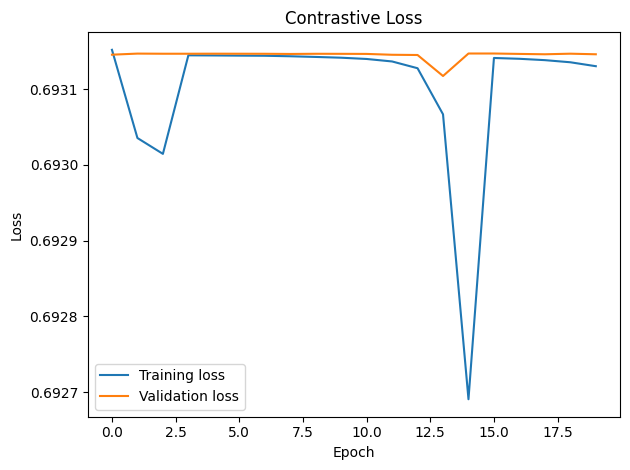

In [8]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

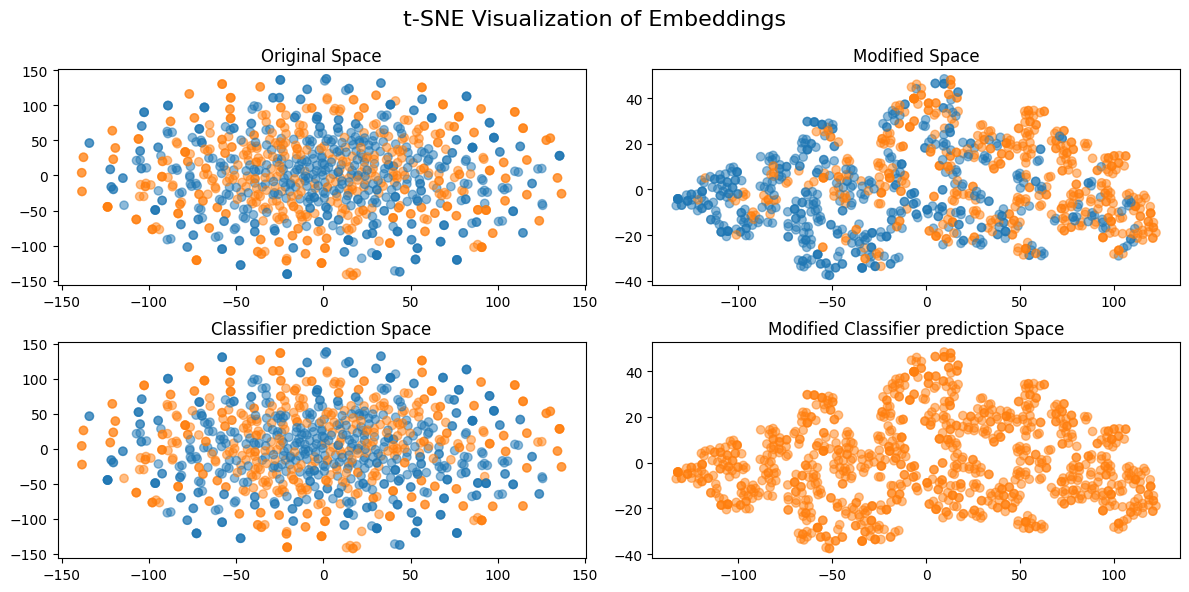

In [9]:
from sklearn.manifold import TSNE as dim_reduction
#from sklearn.decomposition import PCA as dim_reduction
classifier = models.load_model(classifier_path)
best_siamese = models.load_model(model_save_path)
correction = best_siamese.get_layer('correction')

# Choose the dataset to use for visualization
dataset_x = x_test
dataset_y = y_test

# Get sample batch
i = np.random.choice(len(dataset_x), 1000, replace=True)
embedded_true = dataset_x[i]
embedded_new = correction.predict(embedded_true, verbose=0)
labels_true = dataset_y[i]
labels_pred = np.argmax(classifier.predict(embedded_true, verbose=0), axis=1)
labels_new = np.argmax(classifier.predict(embedded_new, verbose=0), axis=1)

# Get low-dimensional Embeddings
h_embedded_true = dim_reduction(n_components=2).fit_transform(embedded_true)
h_embedded_new = dim_reduction(n_components=2).fit_transform(embedded_new)

# Plot
total_classes = len(np.unique(labels_true))
colors = list(plt.cm.tab10.colors[:total_classes])
colors_true = [colors[i] for i in labels_true]
colors_pred = [colors[i] for i in labels_pred]
colors_new = [colors[i] for i in labels_new]

spaces = [
    (h_embedded_true, colors_true, 'Original Space'),
    (h_embedded_new, colors_true, 'Modified Space'),
    (h_embedded_true, colors_pred, 'Classifier prediction Space'),
    (h_embedded_new, colors_new, 'Modified Classifier prediction Space')
]

plt.figure(figsize=(12, 6))
for i, (h, colors, title) in enumerate(spaces):
    plt.subplot(2, 2, i + 1)
    plt.scatter(h[:,0], h[:,1], alpha=0.5, c=colors)
    plt.title(title)
plt.tight_layout()
plt.suptitle('t-SNE Visualization of Embeddings', fontsize=16)
plt.subplots_adjust(top=0.88)  # Adjust the top to make room for the title
plt.show()

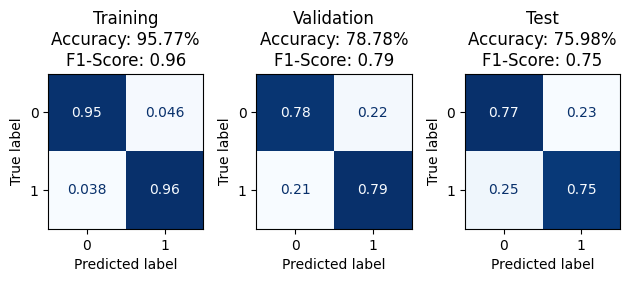

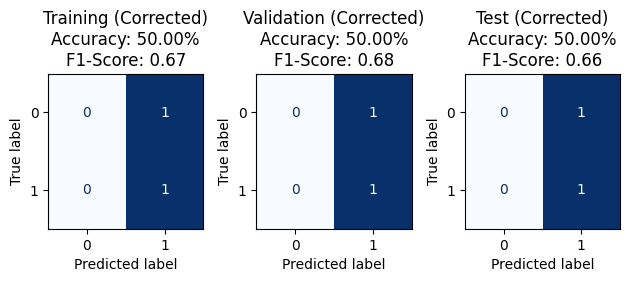

In [10]:
all_datasets = []
all_datasets.append([
    ("Training", y_train, y_train_pred),
    ("Validation", y_val, y_val_pred),
    ("Test", y_test, y_test_pred),
])

y_train_new = np.argmax(classifier.predict(correction.predict(x_train, verbose=0), verbose=0), axis=1)
y_val_new = np.argmax(classifier.predict(correction.predict(x_val, verbose=0), verbose=0), axis=1)
y_test_new = np.argmax(classifier.predict(correction.predict(x_test, verbose=0), verbose=0), axis=1)

all_datasets.append([
    ("Training (Corrected)", y_train, y_train_new),
    ("Validation (Corrected)", y_val, y_val_new),
    ("Test (Corrected)", y_test, y_test_new),
])

for datasets in all_datasets:
    _, axes = plt.subplots(1, len(datasets), figsize=None)
    for i, (title, y_true, y_pred) in enumerate(datasets):
        ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            normalize='true',
            display_labels=[i for i in range(total_classes)],
            cmap=plt.cm.Blues,
            colorbar=False,
            ax=axes[i]
        )
        axes[i].set_title(f"{title}\n"
                            + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                            + f"F1-Score: {f1_score(y_true, y_pred):.2f}")
    plt.tight_layout()
    plt.show()

